# Starbucks Capstone Challenge


## Project Overview
This project is an analysis of Starbucks promotion data. Starbucks periodically sends out offers to users of its mobile app in order to encourage customers to continue purchasing its products. An offer can be an advertisement for a drink or an offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks.

The primary objective of this analysis is to understand whether these promotional offers impact customer purchasing behavior.


## Problem Statement
I will use the provided data to determine how effective the promotions are in encouraging customers to buy Starbucks products. I will also try to understand which demographic subgroups respond better than others.

In order to answer these questions I will employ a variant of an A/B test known as a within-subject analysis, comparing customers' purchasing behavior during the offer periods to their own pre-offer baselines.

## Data Sets

The data provided includes:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



## Metrics 
The key metric for my analysis will be customer spend in dollars. This metric will be broken out according to other attributes such as test and control periods, gender, age, and income in order to help answer the above questions.

I am choosing not to focus on offer completion as a response variable for two reasons:
- the meaning of "offer completion" varies depending on the offer type, so comparing outcomes across offer types may not be as informative as a more universal metric like customer expenditures.
- the impact of promotions on customer expenditures is ultimately of greater business significance than any broadly defined concept of offer completion.
- one key offer type, the informational offer, has no completion parameter so this metric would not even apply to those offers.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from scipy import stats

pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration
### Explore profile dataset
The profile dataset has attribute information for the customers, including gender, age, income, and membership start date. It appears that the dataset contains some missing information.

In [2]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [3]:
print("Percentage of missing gender values:", profile['gender'].isna().sum()/profile.shape[0])
print("Percentage of missing income values:", profile['income'].isna().sum()/profile.shape[0])
print("Percentage of missing age values:", len(profile['age'][profile['age']==118])/profile.shape[0])

Percentage of missing gender values: 0.12794117647058822
Percentage of missing income values: 0.12794117647058822
Percentage of missing age values: 0.12794117647058822


Customers' ages span a wide range with the mode hovering around 60. It appears that ages can also be coded as 118, which may indicate that the customer declined to provide this information.

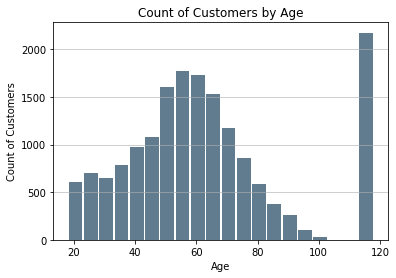

In [4]:
size, scale = 1000, 10
age = pd.Series(profile['age'])
age.head()
age.plot.hist(bins=20, rwidth=0.9, color='#607c8e')
plt.title('Count of Customers by Age')
plt.xlabel('Age')
plt.ylabel('Count of Customers')
plt.grid(axis='y', alpha=0.75)

The distribution of customer incomes is right skewed with the mode hovering around $60,000.

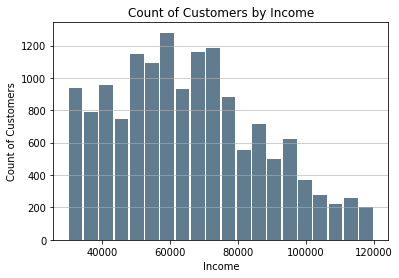

In [5]:
size, scale = 1000, 10
income = pd.Series(profile['income'])
income.head()
income.plot.hist(bins=20, rwidth=0.9, color='#607c8e')
plt.title('Count of Customers by Income')
plt.xlabel('Income')
plt.ylabel('Count of Customers')
plt.grid(axis='y', alpha=0.75)

The dataset contains more males than females. A small proportion of customers have their gender coded as "O". We will treat these as if they are missing.

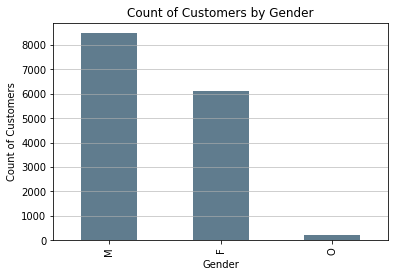

In [6]:
size, scale = 1000, 10
gender = profile['gender'].value_counts()

gender.plot.bar(color='#607c8e')
plt.title('Count of Customers by Gender')
plt.xlabel('Gender')
plt.ylabel('Count of Customers')
plt.grid(axis='y', alpha=0.75)

### Explore portfolio dataset
The portfolio table contains 10 different promotional offers: four bogo offers, four discount offers, and two informational offers. 

A variety of channels are used to communicate the offers to customers. Email is used for all offers.

The rewards vary across offers. Bogo offers have the highest awards on average, followed by discount offers. Informational offers have no monetary value.

For my analysis I will focus on the three offer types as opposed to drilling down into each specific offer. The reason for doing so is that I want to focus on understanding the overall impact of promotions at the offer type level without getting mired in the nuances of specific offers, which may be affected by other factors such as seasonality and customer targeting decisions.

In [7]:
portfolio.sort_values(by='offer_type')

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837


### Explore transcript dataset
The transcript dataset contains all customer level events: transactions, offer received, offer viewed, and offer completed.


In [8]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [9]:
print(transcript['event'].unique())

['offer received' 'offer viewed' 'transaction' 'offer completed']


The most frequently occurring event type is transactions, which is to be expected. A surprisingly high number of offers are viewed and completed: the data seems to suggest that nearly half of received offers are completed.

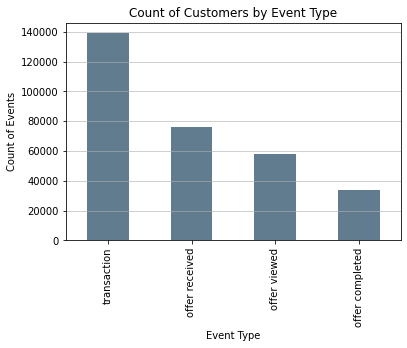

In [10]:
event_counts = transcript['event'].value_counts()

event_counts.plot.bar(color='#607c8e')
plt.title('Count of Customers by Event Type')
plt.xlabel('Event Type')
plt.ylabel('Count of Events')
plt.grid(axis='y', alpha=0.75)

# Methodology

The question I want to answer in this analysis is: what is the impact of Starbucks' promotions on customer expenditures? Presumably the offers increase customer spend, but we want to test that hypothesis and understand the magnitude of the impact if it does exist. We also want to understand how this impact varies across different demographic attributes.

One approach to answering this question is to compare customers who receive one type of offer (test group) to customers who did not receive that same type of offer (control group). However this approach has some potential problems:
- Customers in the control group may be influenced by other offers, and excluding control customers on that basis would reduce the sample size and could bias the results.
- We don't have visibility into why certain customers receive offers in the first place, while others don't. If assignment is non-random, the control group may not provide a valid basis of comparison. Even though we have some customer attributes to better understand how the test group and control group differ, there is always the risk of unobserved differences biasing the results.

For this reason, I will use a within-subjects method to measure the impact of the promotional offers. A within-subjects approach will take customers' expenditures during promotional periods and compare them to a baseline which I define as the period just prior to the promotional period with a duration equal to the duration of the promotion. 

For example: if a customer receives a promotion on Day 10 that lasts for five days (until Day 14), that customer's baseline period is Day 5 to Day 9.

By using customers' own pre-offer purchase history as a baseline, we are able to keep customer attributes constant and minimize bias. While the comparison may not be particularly meaningful for a single customer, comparing customer activity during the baseline period to customer activity during the offer period across a larger population of thousands of customers can generate useful insights. I will also perform statistical tests to determine if any observed differences are statistically significant.



# Clean Data

In [11]:
def clean_offers(transcript, portfolio):
    
    '''
    Create a dataframe with offer details by person. Include the date range for each offer's baseline period, which
    is defined as the period prior to the offer start date with length equal to the offer duration.
    
    INPUT:
    transcript - raw transcript dataframe
    portfolio - raw portfolio dataframe
    
    OUTPUT:
    Cleaned dataframe with offer details by person
    '''
    
    # Create separate offers table and parse the value field to extract the offer type
    offers = transcript[transcript['event'] != 'transaction']
    offers['offer_id'] = offers['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    offers = offers.drop(['value'], axis=1)
    offers = offers[['person', 'offer_id', 'event', 'time']]
    offers = offers.rename(columns={'time': 'offer_start'})

    # Merge in offer type and duration
    offers = offers.merge(portfolio[['id', 'offer_type', 'duration']], left_on='offer_id', right_on='id')
    offers = offers.drop(['id'], axis=1)

    # Generate offer end date and remove duration column
    offers['offer_end'] = offers['offer_start'] + offers['duration'] - 1

    # Create baseline start time
    offers['baseline_start'] = offers['offer_start'] - offers['duration']

    # Retain rows where a BOGO or discount offer was received and instances where an informational offer was viewed
    offers = offers[((offers['offer_type'] == 'bogo') & (offers['event'] == 'offer received')) | 
                    ((offers['offer_type'] == 'discount') & (offers['event'] == 'offer received')) |
                    ((offers['offer_type'] == 'informational') & (offers['event'] == 'offer viewed'))]

    # Drop rows where there is insufficient baseline data (e.g. offer is triggered on Day 0)
    return offers[offers['baseline_start'] >= 0]

offers = clean_offers(transcript, portfolio)
offers.head()

,person,offer_id,event,offer_start,offer_type,duration,offer_end,baseline_start
2521,38fe809add3b4fcf9315a9694bb96ff5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,bogo,7,174,161
2522,389bc3fa690240e798340f5a15918d5c,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,bogo,7,174,161
2523,13bda8fbd70a4814b956df1d55320398,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,bogo,7,174,161
2524,65aba5c617294649aeb624da249e1ee5,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,bogo,7,174,161
2525,3f89b8f80ebc4f94b7074f28071aa8d4,9b98b8c7a33c4b65b9aebfe6a799e6d9,offer received,168,bogo,7,174,161


In [12]:
def clean_transactions(transcript, profile, offers):

    '''
    Create a cleaned dataframe with transactions, offer details, and demographic attributes by person.
    
    INPUT:
    transcript - raw transcript dataframe
    profile - raw profile dataframe
    offers - cleaned offers dataframe, outputted from clean_offers function
    
    OUTPUT:
    Cleaned dataframe with offer details, transaction details, and test/baseline flags by person
    '''

    # Generate clean transactions dataset
    transactions = transcript[transcript['event'] == 'transaction']

    transactions['spend'] = transactions['value'].apply(lambda x: x['amount'])
    transactions = transactions.drop(['value', 'event'], axis=1)

    
    # Join offers details onto transactions table with person ID
    transaction_details = pd.merge(transactions, offers, how = 'left', left_on = ['person'], right_on = ['person'])
    
    # Create test flag
    transaction_details['test_flag'] = np.nan

    # Assign transactions occurring during baseline period a 0, transactions occuring during offer period a 1
    transaction_details['test_flag'][(transaction_details['time'] >= transaction_details['baseline_start']) &
                        (transaction_details['time'] < transaction_details['offer_start'])] = 0

    transaction_details['test_flag'][(transaction_details['time'] >= transaction_details['offer_start']) &
                        (transaction_details['time'] <= transaction_details['offer_end'])] = 1

    # Drop rows where transactions do not fall within the baseline + offer window
    transaction_details = transaction_details[transaction_details['test_flag'].isna() == False]
    
    # Reorder columns
    return transaction_details[['person', 'offer_type', 'offer_id', 'baseline_start', 'offer_start', 'offer_end', 'test_flag', 'time', 'spend']]

transaction_details = clean_transactions(transcript, profile, offers)
transaction_details.head()

,person,offer_type,offer_id,baseline_start,offer_start,offer_end,test_flag,time,spend
2302,37a97f6e09784a07bbb67bc6539f1a00,informational,3f207df678b143eea3cee63160fa8bed,2.0,6.0,9.0,1.0,6,24.25
2535,212a2120b14d4ed88a10d2524c715b28,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,6.0,8.0,1.0,6,0.82
2603,9b265daef0cd4839aabee7f4ee851050,informational,3f207df678b143eea3cee63160fa8bed,2.0,6.0,9.0,1.0,6,35.02
2862,055fe39c422643d89a93cf05cf610b2e,informational,5a8bc65990b245e5a138643cd4eb9837,3.0,6.0,8.0,1.0,6,5.15
2870,9f3a4c78181f4a138f0130ea027a2f3d,informational,3f207df678b143eea3cee63160fa8bed,2.0,6.0,9.0,1.0,6,6.74


In [13]:
def create_analysis_dataset(transaction_details, profile):
    
    '''
    Create a dataset that is ready to be analyzed. This function should take transaction_details and profile tables 
    as inputs and output a table with customer expenditures by person, offer type, and baseline/test period. Customers'
    demographic attributes are also joined onto the table in order to facilitate a subgroup-level analysis.
    
    INPUT:
    transaction_details - Outputted from 'clean_transactions' function
    profile - Raw customer profile table
    
    OUTPUT:
    Clean dataframe that can be used for analysis

    '''
    
    offer_list = transaction_details['offer_type'].unique()
    analysis_dataset = pd.DataFrame()
    
    for i in range(len(offer_list)):

        # From the transaction_details dataframe, create a subset of all people associated with an offer type 
        transaction_subset = transaction_details[transaction_details['offer_type'] == 
                                                 offer_list[i]][['person']].drop_duplicates()
        
        # Join the test period transactions onto a table with person_ids of all customers who received the same offer, 
        # regardless of whether they made a transaction or not.
        transaction_subset_test = pd.merge(transaction_subset, 
                                           transaction_details[(transaction_details['offer_type'] == offer_list[i]) & 
                                                               (transaction_details['test_flag'] == 1)],
                                           how = 'left',
                                           left_on = ['person'],
                                           right_on = ['person'])

        # Fill in missing values in instances where the customer received an offer but did not make a transaction
        transaction_subset_test['test_flag'][transaction_subset_test['test_flag'].isna()==True] = 1
        transaction_subset_test['spend'][transaction_subset_test['spend'].isna()==True] = 0
        transaction_subset_test['offer_type'][transaction_subset_test['offer_type'].isna()==True] = offer_list[i]

        # Join the control period transactions on a table with person_ids of all customers who received the same 
        # offer, regardless of whether they made a transaction or not.
        transaction_subset_control = pd.merge(transaction_subset, 
                                              transaction_details[(transaction_details['offer_type'] == offer_list[i]) & 
                                                                  (transaction_details['test_flag'] == 0)],
                                              how = 'left',
                                              left_on = ['person'],
                                              right_on = ['person'])

        # Fill in missing values in instances where the customer received an offer but did not make a transaction
        transaction_subset_control['test_flag'][transaction_subset_control['test_flag'].isna()==True] = 0
        transaction_subset_control['spend'][transaction_subset_control['spend'].isna()==True] = 0
        transaction_subset_control['offer_type'][transaction_subset_control['offer_type'].isna()==True] = offer_list[i]
        
        # Concatenate the test and control transactions data and append to main table
        transaction_subset = pd.concat([transaction_subset_test, transaction_subset_control])
        analysis_dataset = analysis_dataset.append(transaction_subset)
        
    # Join demographic details from profile data to dataframe
    analysis_dataset = pd.merge(analysis_dataset, profile[['id', 'age', 'gender', 'income']], how = 'left', left_on = ['person'], right_on = ['id'])

    # Impute income as average when value is missing; using average is preferred over dropping the observations entirely
    analysis_dataset['income'][analysis_dataset['income'].isna()==True] = analysis_dataset['income'].mean()
    
    # Impute age as average when value is missing; using average is preferred over dropping the observations entirely
    analysis_dataset['age'][analysis_dataset['age']==118] = analysis_dataset['age'].mean()
    analysis_dataset['age'][analysis_dataset['age'].isna()==True] = analysis_dataset['age'].mean()
    
    # Recode missing gender values as 'Unknown'
    analysis_dataset['gender'][(analysis_dataset['gender'].isna()==True) | (analysis_dataset['gender']=='O')] = 'Unknown'   

    # Sum purchase amounts by person and test_flag
    analysis_dataset = analysis_dataset.groupby(['person', 'offer_type', 'age', 'gender', 'income', 'test_flag'], as_index=False).sum()
        
    return analysis_dataset

In [14]:
analysis_dataset = create_analysis_dataset(transaction_details, profile)
analysis_dataset.head()

,person,offer_type,age,gender,income,test_flag,baseline_start,offer_start,offer_end,time,spend
0,0009655768c64bdeb2e877511632db8f,discount,33.0,M,72000.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0009655768c64bdeb2e877511632db8f,discount,33.0,M,72000.0,1.0,569.0,576.0,582.0,576.0,10.27
2,003d66b6608740288d6cc97a6903f4f0,discount,26.0,F,73000.0,0.0,398.0,408.0,417.0,402.0,5.94
3,003d66b6608740288d6cc97a6903f4f0,discount,26.0,F,73000.0,1.0,494.0,504.0,513.0,504.0,5.01
4,00426fe3ffde4c6b9cb9ad6d077a13ea,discount,19.0,F,65000.0,0.0,0.0,0.0,0.0,0.0,0.00


# Perform Analysis

## Comparing offer behavior to baseline

By comparing the sales during the offer period to the sales during the baseline period, we are able to measure the impact of the promotions on sales. I show the comparison across all three offer types. 

In [15]:
# Create function that calculates the sales means to measure impacts

def test_control_analysis(analysis_dataset):
    
    '''
    Calculate means across segments and prepare them for visualization
    
    INPUT:
    analysis_dataset - Outputted from create_analysis_dataset function
    
    OUTPUT:
    Resulting comparison of means across segments

    '''
    
    offer_list = analysis_dataset['offer_type'].unique()
    results = pd.DataFrame(columns=['offer_type','group','spend'])
    
    for i in range(len(offer_list)):
        interim_control = pd.DataFrame([[offer_list[i],
                                         'control',
                                         analysis_dataset['spend'][(analysis_dataset['offer_type']==offer_list[i]) &
                                                                   (analysis_dataset['test_flag']==0)].mean()]],
                                       columns=['offer_type','group','spend']
                                      )
                                
        interim_test = pd.DataFrame([[offer_list[i],
                                         'test',
                                         analysis_dataset['spend'][(analysis_dataset['offer_type']==offer_list[i]) &
                                                                   (analysis_dataset['test_flag']==1)].mean()]],
                                       columns=['offer_type','group','spend']
                                      )
        results = results.append([interim_control, interim_test])
        
    return results

In [16]:
analysis_results = test_control_analysis(analysis_dataset)
analysis_results


,offer_type,group,spend
0,discount,control,4.385802
0,discount,test,11.301009
0,informational,control,0.000000
0,informational,test,12.885038
0,bogo,control,3.636433
0,bogo,test,11.735535


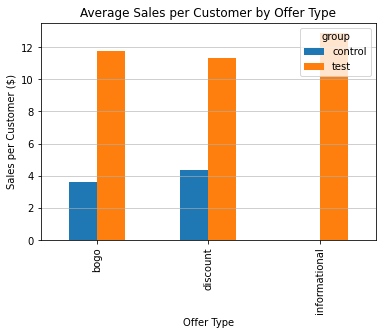

In [17]:
analysis_results.pivot("offer_type", "group", "spend").plot(kind='bar')

plt.title('Average Sales per Customer by Offer Type')
plt.xlabel('Offer Type')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

The above results clearly suggest that the promotional offers have a positive impact on sales, with per customer sales increasing significantly from the baseline period to the offer period for both BOGO offers ($3.64 vs $11.74) and discount offers ($4.39 vs $11.30).

It is notable that customers who received the informational offer had no sales during the baseline period. One possible reason for this is that customers are only sent the informational promotion if they do not make a purchase over a certain number of days. Another possibility is that there is some data quality issue causing this result. In either case, it is a result that warrants further investigation.

Below I run t-tests to ensure that the results above are statistically significant. Not surprisingly, all of the results are statistically significant:

In [18]:
# Informational promotions: t-test
info_control = analysis_dataset['spend'][(analysis_dataset['offer_type']=='informational') &
                                         (analysis_dataset['test_flag']==0)]

info_test = analysis_dataset['spend'][(analysis_dataset['offer_type']=='informational') &
                                      (analysis_dataset['test_flag']==1)]

stats.ttest_ind(info_test, info_control)

Ttest_indResult(statistic=19.886633553072777, pvalue=1.8604958755337624e-81)

In [19]:
# BOGO promotions: t-test
bogo_control = analysis_dataset['spend'][(analysis_dataset['offer_type']=='bogo') &
                                         (analysis_dataset['test_flag']==0)]

bogo_test = analysis_dataset['spend'][(analysis_dataset['offer_type']=='bogo') &
                                      (analysis_dataset['test_flag']==1)]

stats.ttest_ind(bogo_test, bogo_control)


Ttest_indResult(statistic=12.495516748269106, pvalue=2.025111035867442e-35)

In [20]:
# Discount promotions: t-test
discount_control = analysis_dataset['spend'][(analysis_dataset['offer_type']=='discount') &
                                         (analysis_dataset['test_flag']==0)]

discount_test = analysis_dataset['spend'][(analysis_dataset['offer_type']=='discount') &
                                      (analysis_dataset['test_flag']==1)]

print(round(discount_control.mean(), 2))
print(round(discount_test.mean(), 2))

stats.ttest_ind(discount_test, discount_control)

4.39
11.3


Ttest_indResult(statistic=15.021318172108783, pvalue=2.350182851861004e-50)

## Drill down into subgroups

We can do a basic subgroup breakdown for each offer type, looking at how the impacts vary according to gender, age, and income. To enable a subgroup analysis, I segment customers into "high" and "low" income and "high" and "low" age groups. The income line is set at $60,000 which is roughly the mode for the population, and the age line is set at 60, which is roughly the mode for the population. 

In [21]:
analysis_dataset.head()

,person,offer_type,age,gender,income,test_flag,baseline_start,offer_start,offer_end,time,spend
0,0009655768c64bdeb2e877511632db8f,discount,33.0,M,72000.0,0.0,0.0,0.0,0.0,0.0,0.00
1,0009655768c64bdeb2e877511632db8f,discount,33.0,M,72000.0,1.0,569.0,576.0,582.0,576.0,10.27
2,003d66b6608740288d6cc97a6903f4f0,discount,26.0,F,73000.0,0.0,398.0,408.0,417.0,402.0,5.94
3,003d66b6608740288d6cc97a6903f4f0,discount,26.0,F,73000.0,1.0,494.0,504.0,513.0,504.0,5.01
4,00426fe3ffde4c6b9cb9ad6d077a13ea,discount,19.0,F,65000.0,0.0,0.0,0.0,0.0,0.0,0.00


In [22]:
# Create binary customer demographic segments for age and income
results = pd.DataFrame(columns=['demog_category', 'attribute', 'group', 'spend'])
age_split = 60
income_split = 50000

analysis_dataset['age_cat'] = np.nan
analysis_dataset['age_cat'][analysis_dataset['age'] < age_split] = "Low"
analysis_dataset['age_cat'][analysis_dataset['age'] >= age_split] = "High"

analysis_dataset['income_cat'] = np.nan
analysis_dataset['income_cat'][analysis_dataset['income'] < income_split] = "Low"
analysis_dataset['income_cat'][analysis_dataset['income'] >= income_split] = "High"

With the binary age and income variables established, I can further segment the dollar impacts along these dimensions.

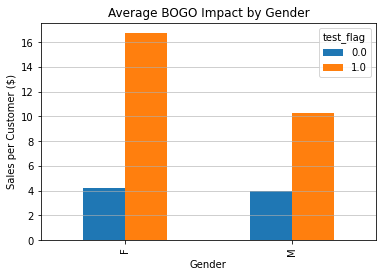

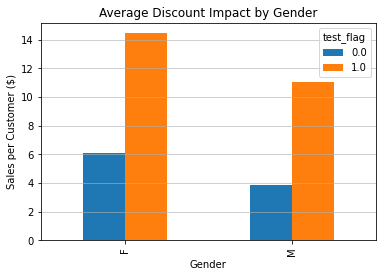

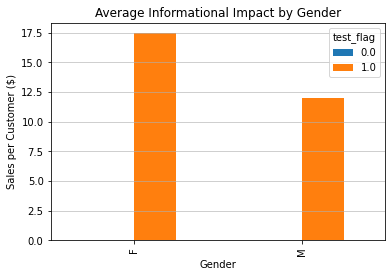

In [26]:
# Generate comparisons for each offer type by gender 

gender = analysis_dataset[['offer_type', 'gender', 'test_flag', 'spend']].groupby(['offer_type', 'gender', 'test_flag'], as_index=False).mean()

gender['demog_category'] = 'gender'
gender = gender[['offer_type', 'demog_category', 'gender', 'test_flag', 'spend']]
gender.columns = ['offer_type', 'demog_category', 'attribute', 'test_flag', 'spend']
gender = gender[gender['attribute'] != 'Unknown']

gender[gender['offer_type']=='bogo'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average BOGO Impact by Gender')
plt.xlabel('Gender')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

gender[gender['offer_type']=='discount'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average Discount Impact by Gender')
plt.xlabel('Gender')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

gender[gender['offer_type']=='informational'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average Informational Impact by Gender')
plt.xlabel('Gender')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

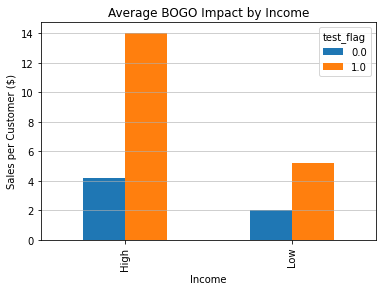

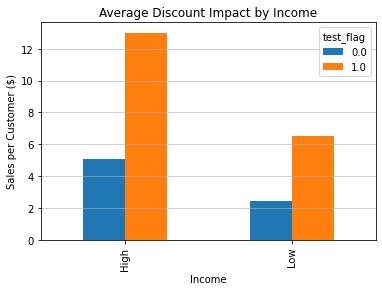

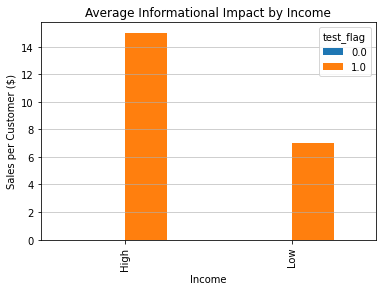

In [27]:
# Generate comparisons for each offer type by income 

income = analysis_dataset[['offer_type', 'income_cat', 'test_flag', 'spend']].groupby(['offer_type', 'income_cat', 'test_flag'], as_index=False).mean()

income['demog_category'] = 'income'
income = income[['offer_type', 'demog_category', 'income_cat', 'test_flag', 'spend']]
income.columns = ['offer_type', 'demog_category', 'attribute', 'test_flag', 'spend']
income = income[income['attribute'] != 'Unknown']

income[income['offer_type']=='bogo'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average BOGO Impact by Income')
plt.xlabel('Income')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

income[income['offer_type']=='discount'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average Discount Impact by Income')
plt.xlabel('Income')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

income[income['offer_type']=='informational'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average Informational Impact by Income')
plt.xlabel('Income')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)


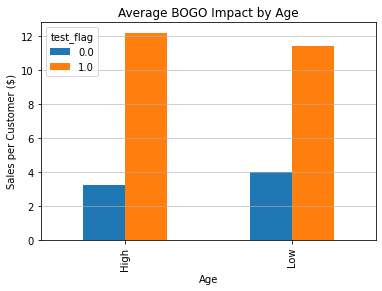

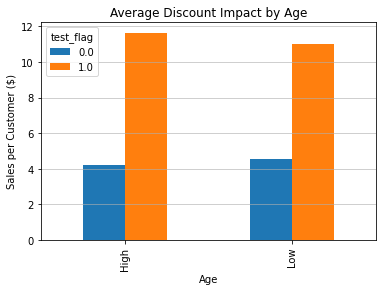

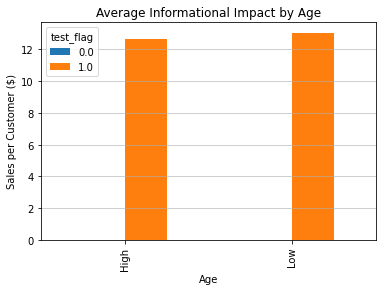

In [28]:
# Generate comparisons for each offer type by age

age = analysis_dataset[['offer_type', 'age_cat', 'test_flag', 'spend']].groupby(['offer_type', 'age_cat', 'test_flag'], as_index=False).mean()

age['demog_category'] = 'age'
age = age[['offer_type', 'demog_category', 'age_cat', 'test_flag', 'spend']]
age.columns = ['offer_type', 'demog_category', 'attribute', 'test_flag', 'spend']
age = age[age['attribute'] != 'Unknown']

age[age['offer_type']=='bogo'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average BOGO Impact by Age')
plt.xlabel('Age')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

age[age['offer_type']=='discount'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average Discount Impact by Age')
plt.xlabel('Age')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)

age[age['offer_type']=='informational'].pivot('attribute', 'test_flag',  'spend').plot(kind='bar')
plt.title('Average Informational Impact by Age')
plt.xlabel('Age')
plt.ylabel('Sales per Customer ($)')
plt.grid(axis='y', alpha=0.75)


The above results reveal a couple notable findings:

- Female and male customers have similar baseline spending habits, but female customers respond much more strongly to BOGO offers. Female customers also respond more strongly to discount and informational offers, however the difference is most pronounced for BOGO offers.
- Higher income customers have higher baseline spending habits and respond more strongly to promotional offers
- Segmenting by age does not reveal significant differences in baseline spending habits or promotional offer response.

These findings suggest that promotions are particularly effective among higher income female customers, although it is clear that this segment of the customer population is not the only group that is shown to respond to the promotional offers.

# Conclusion

This analysis set out to understand whether Starbucks' promotional offers affect customer spending habits. A within-subjects analysis was used to compare customers' purchase history during offer periods to their baseline periods, which were defined as the time period prior to customers receiving a promotion.

We can confidently conclude that the promotions do have a statistically significant and substantive impact on customer spending habits. All three offer types appear to drive higher customer purchasing activity. Looking within subgroups, female and high income customers respond most strongly to the offers. 

### Reflection
This was an interesting project that involved relatively complex data and required me to think through different methodological tradeoffs. I needed to figure out where to simplify the data and analysis in order to come up with a methodology that would be practical and understandable. 

For example, I chose to focus on the three broad offer types instead of the 10 individual offers. And I chose to focus on customer spend as the key metric of interest as opposed to offer completion. I made these choices in part to address the relatively low sample sizes provided and mitigate the odds of arriving at false positive results. 

I also chose the within-subjects approach to estimate causal impacts, which seemed most practical given the nature of the data, with customers receiving offers at various times across the entire time series. 

### Improvement
There are several opportunities for further analysis. More nuanced customer segmentation approaches could be used to better understand how groups respond differently to the offers (however it would be necessary to avoid splitting the population into too many groups, which would lead to smaller sample sizes). It could also be worth looking at specific offers within an offer type in order to better understand what aspects of the promotions (e.g. incentive size, offer duration) can also influence customer behavior.